In [17]:
#!/usr/bin/env python
# coding: utf-8
from tqdm  import tqdm 
from tqdm import trange
from pyDOE import lhs
import torch
torch.cuda.empty_cache()

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
warnings.filterwarnings('ignore')



import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False   # 设置显示负号

np.random.seed(2023)
# 检查是否有可用的GPU设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


MESH

In [18]:
import re
import matplotlib.pyplot as plt
import numpy as np

def extract_mesh_from_inp(file_path):
    """
    从 Abaqus .inp 文件中提取节点和 CPE3 元素信息，转换节点索引为 0-based。
    
    参数：
        file_path: .inp 文件路径。
    
    返回：
        nodes: list of (node_id, x, y)，节点 ID (0-based) 和坐标（仅 x, y）。
        elements: list of [node_id1, node_id2, node_id3]，单元的节点索引 (0-based)。
        node_sets: dict，节点集。
        element_type: str，单元类型（如 'CPE3'）。
    """
    nodes = []
    elements = []
    node_sets = {}
    element_type = None

    with open(file_path, 'r') as f:
        reading_nodes = False
        reading_elements = False
        reading_nsets = False
        current_nset = None

        for line in f:
            line = line.strip()
            if line.startswith("*Node"):
                reading_nodes = True
                reading_elements = False
                reading_nsets = False
                continue
            elif line.startswith("*Element"):
                reading_nodes = False
                reading_elements = True
                reading_nsets = False
                element_type_match = re.search(r"type=(\w+)", line)
                element_type = element_type_match.group(1) if element_type_match else None
                continue
            elif line.startswith("*Nset"):
                reading_nodes = False
                reading_elements = False
                reading_nsets = True
                current_nset = line.split('=')[-1].strip()
                node_sets[current_nset] = []
                continue
            elif line.startswith("*End") or line.startswith("*Elset"):
                reading_nodes = False
                reading_elements = False
                reading_nsets = False
                continue
            if reading_nodes:
                node_data = re.split(r',\s*', line.strip())
                if len(node_data) >= 3:  # CPE3 只需 x, y 坐标
                    try:
                        node_id = int(node_data[0]) - 1  # 转换为 0-based
                        x, y = map(float, node_data[1:3])  # 只取 x, y
                        nodes.append((node_id, x, y))
                    except ValueError:
                        continue
            if reading_elements:
                element_data = re.split(r',\s*', line.strip())
                if len(element_data) >= 4:  # CPE3: 1 element_id + 3 node_ids
                    try:
                        element_nodes = [int(n) - 1 for n in element_data[1:4]]  # 转换为 0-based
                        if element_type == "CPE3" and len(element_nodes) == 3:
                            elements.append(element_nodes)
                        else:
                            print(f"警告: 单元 {element_data[0]} 被跳过，无效节点数或类型")
                    except ValueError:
                        print(f"警告: 行数据无效: {line}")
                        continue
            if reading_nsets:
                if "generate" in line.lower():
                    node_ids = re.split(r',\s*', line.strip())
                    if len(node_ids) >= 3:
                        try:
                            start, end, step = map(int, node_ids[:3])
                            node_sets[current_nset].extend([n - 1 for n in range(start, end + 1, step)])
                        except ValueError:
                            continue
                else:
                    node_ids = re.split(r',\s*', line.strip())
                    if all(nid.strip().isdigit() for nid in node_ids if nid.strip()):
                        node_sets[current_nset].extend([int(nid) - 1 for nid in node_ids if nid.strip()])

    # 检查节点索引有效性
    max_node_id = max([n[0] for n in nodes]) if nodes else -1
    for e, elem in enumerate(elements):
        for nid in elem:
            if nid < 0 or nid > max_node_id:
                print(f"错误: 单元 {e+1} 包含无效节点索引 {nid + 1} (0-based: {nid})")
                return [], [], {}, None

    return nodes, elements, node_sets, element_type

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import torch  # Assuming PyTorch is used for tensors

def plot_2d_mesh(nodes, elements, gp_coords, path, line_width=1.0, gp_color='red', gp_size=10):
    """
    绘制 CPE3 网格的二维线框可视化，跳过无效三角形，仅显示黑色网格和指定颜色的 gp 点，并保存为 TIFF。

    参数：
        nodes: 节点列表 [(node_id, x, y), ...]
        elements: 元素列表 [[node_id1, node_id2, node_id3], ...]
        gp_coords: 高斯积分点坐标列表 [(x, y), ...] 或 PyTorch tensor
        path: 保存 TIFF 文件的路径（包括文件名，例如 'output/mesh.tiff'）
        line_width: 网格线条宽度，默认为 1.0
        gp_color: gp 点的颜色，默认为 'red'
        gp_size: gp 点的大小，默认为 10
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)

    # 提取节点坐标
    nodes_array = np.array([n[1:3] for n in nodes])  # (num_nodes, 2)


    invalid_elements = 0

    # 绘制三角形元素
    for e, node_ids in enumerate(elements):
        coords = nodes_array[node_ids]
        if len(set(node_ids)) != 3:
            print(f"警告: 单元 {e} 存在重复节点: {node_ids}")
            invalid_elements += 1
            continue

        x = coords[:, 0]
        y = coords[:, 1]
        v1 = coords[1] - coords[0]
        v2 = coords[2] - coords[0]
        area = 0.5 * abs(np.cross(v1, v2))
        if area < 1e-10:
            print(f"警告: 单元 {e} 面积接近零 {area}，跳过")
            invalid_elements += 1
            continue

        x = list(x) + [x[0]]
        y = list(y) + [y[0]]
        ax.plot(x, y, 'k-', linewidth=line_width)


    # 绘制高斯积分点
    if gp_coords is not None and len(gp_coords) > 0:
        if isinstance(gp_coords, torch.Tensor):
            gp_array = gp_coords.detach().cpu().numpy()
        else:
            gp_array = np.array(gp_coords)
        print(f"高斯积分点数量: {len(gp_array)}")
        print(f"高斯积分点坐标范围: x=[{gp_array[:,0].min()}, {gp_array[:,0].max()}], y=[{gp_array[:,1].min()}, {gp_array[:,1].max()}]")
        ax.scatter(gp_array[:, 0], gp_array[:, 1], c=gp_color, s=gp_size)

    # 设置坐标轴范围（自动适应数据）
    if len(nodes_array) > 0:
        x_min, x_max = nodes_array[:, 0].min(), nodes_array[:, 0].max()
        y_min, y_max = nodes_array[:, 1].min(), nodes_array[:, 1].max()
        margin = 0.1 * max(x_max - x_min, y_max - y_min) or 1.0  # 添加 10% 边距
        ax.set_xlim(x_min - margin, x_max + margin)
        ax.set_ylim(y_min - margin, y_max + margin)
        print(f"设置坐标范围: x=[{x_min - margin}, {x_max + margin}], y=[{y_min - margin}, {y_max + margin}]")

    ax.axis('off')  # 关闭坐标轴
    plt.axis('equal')  # 确保比例相等
    plt.tight_layout()  # 优化布局

    # 强制渲染图形
    fig.canvas.draw()

    # 保存为 TIFF（移除 compression 参数以兼容旧版本）
    plt.savefig(path, format='tiff', dpi=600)
    print(f"图片已保存至: {path}")
    plt.close(fig)  # 关闭图形释放内存

单线段的R函数距离

In [19]:
def dist(x1, y1, x2, y2):
    """计算两点间距离"""
    return torch.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def linseg(x, y, x1, y1, x2, y2):
    """单线段的R函数距离，防止零值"""
    eps=1e-20
    L = dist(x1, y1, x2, y2)
    L = torch.where(L > eps, L, eps)  # 防止除零
    xc = (x1 + x2) / 2.0
    yc = (y1 + y2) / 2.0
    f = (1.0 / L) * ((x - x1) * (y2 - y1) - (y - y1) * (x2 - x1))
    t = (1.0 / L) * ((L / 2.0)**2 - dist(x, y, xc, yc)**2)
    varphi = torch.sqrt(t**2 + f**4 + eps)
    phi_i = torch.sqrt(f**2 + (1.0 / 4.0) * (varphi - t)**2 + eps)
    return phi_i

# def phi(x, y, segments, m=1.0):
#     """多边形R函数距离，基于边集合"""
#     R = torch.zeros_like(x)
#     for i in range(len(segments)):
#         # 直接从segments中提取每条边的起点和终点
#         x1, y1 = segments[i, 0]  # 第一顶点 [x1, y1]
#         x2, y2 = segments[i, 1]  # 第二顶点 [x2, y2]
#         phi_i = linseg(x, y, x1, y1, x2, y2)
#         R += 1.0 / phi_i**m
#     return 1.0 / R**(1.0 / m)
def phi(x, y, segments=None, data=None, m=1.0):
    """多边形R函数距离，基于边集合，并融合点的集合"""
    eps = 1e-20
    R = torch.zeros_like(x)
    
    # 处理线段
    if segments is not None:
        for i in range(len(segments)):
            # 直接从segments中提取每条边的起点和终点
            x1, y1 = segments[i, 0]  # 第一顶点 [x1, y1]
            x2, y2 = segments[i, 1]  # 第二顶点 [x2, y2]
            phi_i = linseg(x, y, x1, y1, x2, y2)
            R += 1.0 / phi_i**m
    
    # 处理点集合（如果提供）
    if data is not None:
        for i in range(len(data)):
            px, py = data[i]
            phi_i = dist(x, y, px, py)
            phi_i = torch.where(phi_i > eps, phi_i, eps)  # 防止除零
            R += 1.0 / phi_i**m
    
    # 如果R为零（无元素），返回一个默认大值或处理边缘情况
    R = torch.where(R > eps, R, eps)  # 防止整体除零
    
    return 1.0 / R**(1.0 / m)

定义非同质边界条件 g(x)

In [20]:
# def boundary_g(x, y, segments, bc_values):
#     """超限插值构造 g(x, y)，基于边集合"""
#     mu = 1.0
#     weights = []
#     for i in range(len(segments)):
#         x1, y1 = segments[i, 0]
#         x2, y2 = segments[i, 1]
#         phi_i = linseg(x, y, x1, y1, x2, y2)
#         weights.append(phi_i**(-mu))

    
#     weights = torch.stack(weights)

#     g_values = torch.tensor(bc_values, dtype=torch.float32, device=x.device)

#     w = weights / torch.sum(weights, dim=0)
#     g = torch.sum(w * g_values.view(-1, 1, 1), dim=0)
   
#     return g

def boundary_g(x, y,bc_values, segments=None,  data=None):
    """超限插值构造 g(x, y)，基于边集合和点集合（如果提供）"""
    mu = 1.0
    weights = []
    
    # 处理线段
    if segments is not None:
        for i in range(len(segments)):
            x1, y1 = segments[i, 0]
            x2, y2 = segments[i, 1]
            phi_i = linseg(x, y, x1, y1, x2, y2)
            weights.append(phi_i**(-mu))
    
    # 处理点集合（如果提供）
    if data is not None:
        for i in range(len(data)):
            px, py = data[i]
            phi_i = dist(x, y, px, py)
            phi_i = torch.where(phi_i > 1e-20, phi_i, 1e-20)  # 防止除零
            weights.append(phi_i**(-mu))
    
    # 堆叠权重
    weights = torch.stack(weights)


    g_values = torch.tensor(bc_values, dtype=torch.float32, device=x.device)

    # 计算加权平均
    w = weights / torch.sum(weights, dim=0)
    g = torch.sum(w * g_values.view(-1, 1, 1), dim=0)
   
    return g

绘制距离函数云图

In [21]:
def plot_phi(bc,point=None,n_grid=100):
    x = torch.linspace(-1.5, 1.5, n_grid)
    y = torch.linspace(-1.5, 1.5, n_grid)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    X_flat, Y_flat = X.reshape(-1), Y.reshape(-1)
    
    phi_vals = phi(X_flat, Y_flat, bc,point).reshape(n_grid, n_grid).cpu().detach().numpy()
    
    plt.figure(figsize=(8, 6))
    plt.contourf(X.cpu(), Y.cpu(), phi_vals, levels=20, cmap='viridis')
    plt.colorbar(label='Distance Function φ(x, y)')
    

    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

shape function

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

def compute_shape_functions(nodes, elements):
    """
    预计算每个单元高斯积分点的全局形函数及其导数，适应顺时针或逆时针
    参数：
        nodes: 节点坐标，形状为 (num_nodes, 2)
        elements: 单元连接，形状为 (num_elements, 3)
        device: PyTorch 设备
    返回：
        gauss_points: 积分点坐标，形状为 (num_elements, 2)
        shape_vals: 形函数值，形状为 (num_elements, num_nodes)
        shape_grads: 形函数导数，形状为 (num_elements, num_nodes, 2)
        areas: 单元面积，形状为 (num_elements,)
    """
    num_elements = elements.shape[0]
    num_nodes = nodes.shape[0]
    gauss_points = []
    shape_vals = np.zeros((num_elements, num_nodes))
    shape_grads = np.zeros((num_elements, num_nodes, 2))
    areas = np.zeros(num_elements)
    negative_grad_count = 0
    total_grad_count = 0
    for e, elem in enumerate(elements):
        x1, y1 = nodes[elem[0]]
        x2, y2 = nodes[elem[1]]
        x3, y3 = nodes[elem[2]]
        A_signed = 0.5 * ((x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1))
        if A_signed < 0:  # 顺时针，翻转
            elements[e] = [elem[0], elem[2], elem[1]]
            x2, y2, x3, y3 = x3, y3, x2, y2
            A_signed = -A_signed
        A = abs(A_signed)
        if A < 1e-10:
            print(f"Warning: Element {e} has near-zero area: {A}")
            A = 1e-10
        areas[e] = A

        x_g = (x1 + x2 + x3) / 3
        y_g = (y1 + y2 + y3) / 3
        gauss_points.append([x_g, y_g])

        A1 = 0.5 * ((x2 - x_g)*(y3 - y_g) - (x3 - x_g)*(y2 - y_g))
        A2 = 0.5 * ((x3 - x_g)*(y1 - y_g) - (x1 - x_g)*(y3 - y_g))
        A3 = 0.5 * ((x1 - x_g)*(y2 - y_g) - (x2 - x_g)*(y1 - y_g))
        N1 = A1 / A_signed
        N2 = A2 / A_signed
        N3 = A3 / A_signed

        N_total = N1 + N2 + N3
        expected = 0.3333333333333333
        if abs(N_total - 1.0) > 1e-6 or min(N1, N2, N3) < -1e-6:
            print(f"Element {e}: Shape function sum={N_total}, N1={N1}, N2={N2}, N3={N3}, A_signed={A_signed}")
        elif abs(N1 - expected) > 1e-6 or abs(N2 - expected) > 1e-6 or abs(N3 - expected) > 1e-6:
            print(f"Element {e}: Unexpected shape functions, N1={N1}, N2={N2}, N3={N3}")

        shape_vals[e, elem[0]] = N1
        shape_vals[e, elem[1]] = N2
        shape_vals[e, elem[2]] = N3

        b1, b2, b3 = y2 - y3, y3 - y1, y1 - y2
        c1, c2, c3 = x3 - x2, x1 - x3, x2 - x1
        dN_dx = np.array([b1/(2*A), b2/(2*A), b3/(2*A)])
        dN_dy = np.array([c1/(2*A), c2/(2*A), c3/(2*A)])

        for grad in dN_dx:
            total_grad_count += 1
            if grad < 0:
                negative_grad_count += 1
        for grad in dN_dy:
            total_grad_count += 1
            if grad < 0:
                negative_grad_count += 1

        dx_sum = dN_dx.sum()
        dy_sum = dN_dy.sum()
        if abs(dx_sum) > 1e-6 or abs(dy_sum) > 1e-6:
            print(f"Element {e}: dN_dx sum={dx_sum}, dN_dy sum={dy_sum}, dN_dx={dN_dx}, dN_dy={dN_dy}")

        shape_grads[e, elem[0], :] = [dN_dx[0], dN_dy[0]]
        shape_grads[e, elem[1], :] = [dN_dx[1], dN_dy[1]]
        shape_grads[e, elem[2], :] = [dN_dx[2], dN_dy[2]]


    print("Area range:", areas.min(), areas.max())
    print(f"Negative gradients: {negative_grad_count}/{total_grad_count} ({negative_grad_count/total_grad_count*100:.2f}%)")
    return (

        torch.tensor(shape_vals, dtype=torch.float32, device=device),
        torch.tensor(shape_grads, dtype=torch.float32, device=device)

    )

def generate_gp(nodes, elements, device='cpu'):
    """
    生成三角形单元的高斯积分点（形心）和面积。

    参数：
        nodes (np.ndarray): 节点坐标，形状为 (n_nodes, 2)，每行是 [x, y]。
        elements (np.ndarray): 三角形单元索引，形状为 (n_elements, 3)，每行包含三个节点索引。
        device (str): 计算设备，默认为 'cpu'，可选 'cuda'。

    返回：
        Tuple[torch.Tensor, torch.Tensor]:
            - areas: 每个三角形单元的面积，形状为 (n_elements,)。
            - gauss_points: 每个三角形单元的形心坐标，形状为 (n_elements, 2)。
    """
    # 转换为 NumPy 数组（确保输入格式一致）
    nodes = np.asarray(nodes)
    elements = np.asarray(elements)

    # 获取三角形三个顶点的坐标
    node1 = nodes[elements[:, 0]]  # 形状：(n_elements, 2)
    node2 = nodes[elements[:, 1]]  # 形状：(n_elements, 2)
    node3 = nodes[elements[:, 2]]  # 形状：(n_elements, 2)

    # 计算面积（使用向量叉积公式）
    x1, y1 = node1[:, 0], node1[:, 1]
    x2, y2 = node2[:, 0], node2[:, 1]
    x3, y3 = node3[:, 0], node3[:, 1]
    areas = 0.5 * np.abs((x2 - x1) * (y3 - y1) - (x3 - x1) * (y2 - y1))

    # 检查面积是否接近零
    min_area = 1e-10
    if np.any(areas < min_area):
        print(f"Warning: {np.sum(areas < min_area)} elements have area < {min_area}. Setting to {min_area}.")
        areas = np.maximum(areas, min_area)

    # 计算形心（三个顶点坐标的平均值）
    gauss_points = (node1 + node2 + node3) / 3.0

    # 转换为 PyTorch 张量并移动到指定设备
    areas = torch.tensor(areas, dtype=torch.float32, device=device)
    gauss_points = torch.tensor(gauss_points, dtype=torch.float32, device=device)

    return areas, gauss_points


#########  PINN  ######### 

In [26]:
# 均方误差 MSE
mse_loss = torch.nn.MSELoss() 

# 定义 MAE 损失(绝对误差)
mae_loss = nn.L1Loss()

In [28]:
import time
from torch.optim import lr_scheduler
from scipy.spatial import Delaunay
from scipy.spatial import Voronoi, voronoi_plot_2d
import torch.nn.init as init
class PINNs():
    def __init__(
        self, 
        activation, 
        device,
        initial_lr, sadap,
        rho, E, nu,
        segments_x, segments_y, bc_x, bc_y, bc_s11, bc_s22, bc_s12,
        data_x, data_y,

        gp,  gp_shape, gp_shape_grad, areas,
        mesh_nodes,
        loss_threshold


    ):
        self.E = torch.tensor(E, dtype=torch.float32, device=device, requires_grad=True)

        self.nu = torch.tensor(nu, dtype=torch.float32, device=device, requires_grad=True)
        # self.E = 0.0
        # self.nu = 0.0

        self.device = device
        # self.t_point = t_point
        ###  材料参数  ###
        self.lambda_ = torch.tensor(E * nu / ((1 + nu) * (1 - 2 * nu)), dtype=torch.float32, device=device, requires_grad=True)
        self.G = torch.tensor(E / (2 * (1 + nu)), dtype=torch.float32, device=device, requires_grad=True)
        # self.c11 = self.c22 = self.lambda_ + 2 * self.G
        # self.c12 = self.c21 = self.lambda_
        # self.c33 = self.G

        self.iter_res=0
        self.iter_phi=0
        self.rho = rho
           
        self.train_losses = []
        self.train_losses_phi = []
        self.end_time = []
        self.E_time = []
        self.nu_time = []
        self.segments_x = segments_x
        self.segments_y = segments_y
        self.data_x = data_x
        self.data_y = data_y
        self.bc_x = bc_x
        self.bc_y = bc_y
        self.bc_s11 = bc_s11
        self.bc_s22 = bc_s22
        self.bc_s12 = bc_s12

        self.gp = torch.tensor(gp, dtype=torch.float32, device=device)
        self.gp_shape = torch.tensor(gp_shape, dtype=torch.float32, device=device)
        self.gp_shape_grad_x = torch.tensor(gp_shape_grad[:, :, 0], dtype=torch.float32, device=device)
        self.gp_shape_grad_y = torch.tensor(gp_shape_grad[:, :, 1], dtype=torch.float32, device=device)

        self.areas = torch.tensor(areas, dtype=torch.float32, device=device)

        beta_init = 0.0  # 初始值
        ##u

        self.gp_x = self.gp[:, 0].reshape(-1, 1)  # [N, 1]  
        self.gp_y = self.gp[:, 1].reshape(-1, 1)


        self.mesh_nodes = torch.tensor(mesh_nodes, dtype=torch.float32, device=device)
        self.mesh_nodes_x = self.mesh_nodes[:, 0].reshape(-1, 1)  # [N, 1]
        self.mesh_nodes_y = self.mesh_nodes[:, 1].reshape(-1, 1)
        

        # ####
        self.beta_u = torch.full(self.mesh_nodes_x.shape, beta_init, requires_grad=True, device=device)  #

        self.beta_v = torch.full(self.mesh_nodes_y.shape, beta_init, requires_grad=True, device=device)  #

        self.beta_s11 = torch.full(self.mesh_nodes_x.shape, beta_init, requires_grad=True, device=device)  #
        self.beta_s22 = torch.full(self.mesh_nodes_x.shape, beta_init, requires_grad=True, device=device)  #
        self.beta_s12 = torch.full(self.mesh_nodes_x.shape, beta_init, requires_grad=True, device=device)  #

        # self.beta_u = torch.empty(self.mesh_nodes_x.shape + (1,), requires_grad=True, device=device)  # 形状从 [n] 变为 [n, 1]
        # init.xavier_uniform_(self.beta_u)  # 应用 Xavier 初始化
        # self.beta_u = self.beta_u.squeeze(-1)  # 恢复为 [n]


        # self.beta_v = torch.empty(self.mesh_nodes_y.shape + (1,), requires_grad=True, device=device)
        # init.xavier_uniform_(self.beta_v)
        # self.beta_v = self.beta_v.squeeze(-1)
        
        # self.beta_u = torch.tensor(self.beta_u, requires_grad=True, device=device)  # 确保是张量
        # self.beta_v = torch.tensor(self.beta_v, requires_grad=True, device=device)  # 确保是张量            



        xx =  (torch.tensor(mesh_nodes).float().to(device))[:, 0].reshape(-1, 1) 
        yy =  (torch.tensor(mesh_nodes).float().to(device))[:, 1].reshape(-1, 1) 
        ##u
        self.phi_val_u= phi(xx, yy, self.segments_x, self.data_x)
        # self.phi_val_u= phi(xx, yy, self.segments_x, data = None)
        self.g_val_u = boundary_g(xx, yy, self.bc_x,self.segments_x,  self.data_x)
        # self.g_val_u = boundary_g(xx, yy, self.bc_x,self.segments_x, data = None)


        ##v
        self.phi_val_v = phi(xx, yy, self.segments_y,self.data_y )
        self.g_val_v = boundary_g(xx, yy, self.bc_y,self.segments_y,  self.data_y)

        ##s11
        self.phi_val_s11 = phi(xx, yy, segments=None, data =self.data_x)
        self.g_val_s11 = boundary_g(xx, yy,self.bc_s11, None,  self.data_x)

        ##s22
        self.phi_val_s22 = phi(xx, yy, None, self.data_x)
        self.g_val_s22 = boundary_g(xx, yy, self.bc_s22,None,  self.data_x)

        ##s12
        self.phi_val_s12 = phi(xx, yy, None, self.data_x)
        self.g_val_s12 = boundary_g(xx, yy, self.bc_s12,None,  self.data_x)

        ############################################


        # 优化器：使用相同的设置
        self.optimizer_res = torch.optim.LBFGS(
            [self.beta_u,self.beta_v,self.lambda_,self.G,self.beta_s11,self.beta_s22,self.beta_s12], 
            lr=initial_lr, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change = 1e-5 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # 使用强沃尔夫线搜索条件
        )


     
        self.sadap_res=sadap #自适应学习率（是否）  每次更新时将学习率乘以 0.9（即每 1000 次迭代后，学习率减小到 90%）


        self.optimizer_Adam_res = torch.optim.Adam(params=[self.beta_u,self.beta_v,self.lambda_,self.G,self.beta_s11,self.beta_s22,self.beta_s12], lr=initial_lr)


        if self.sadap_res:
            self.scheduler_res = lr_scheduler.StepLR(self.optimizer_Adam_res, step_size=1000, gamma=0.9)

     # def optim_Adam(self,model):
    #     opt_adam = torch.optim.Adam(params=model.parameters(), lr=self.initial_lr)
    #     return opt_adam
    def update_material_params(self):
        # self.E.data = torch.clamp(self.E, 1e-6, 1e6)
        # self.nu.data = torch.clamp(self.nu, 0.01, 0.49)
        # # ... 后续计算 ...

        # self.lambda_ = self.E * self.nu / ((1 + self.nu) * (1 - 2 * self.nu))
        # self.G = self.E / (2 * (1 + self.nu))
        self.c11 = self.c22 = self.lambda_ + 2 * self.G
        self.c12 = self.c21 = self.lambda_
        self.c33 = self.G
 
    def xavier_init(self,layer):
        """
        对神经网络层进行 Xavier 初始化，包括权重和偏置
        
        Parameters:
            - layer (torch.nn.Module): 神经网络层
            
        Notes:
            该函数用于初始化线性层（nn.Linear），使用 Xavier 初始化方法，即将权重初始化为均匀分布，
            将偏置初始化为零。
        """
        if isinstance(layer, nn.Linear):  # 检查是否为线性层
            nn.init.xavier_uniform_(layer.weight)  # 使用Xavier初始化方法初始化权重
            nn.init.zeros_(layer.bias)  # 将偏置初始化为零

    


    #########################
    #######         #########
    #######  train  #########
    #######         #########
    #########################
    def closure_res(self):
            self.optimizer_res.zero_grad()
            self.update_material_params()
            loss = self.loss_res_all(td=None, print_str="", loss_model=torch.nn.MSELoss())
            if torch.isnan(loss).any() or torch.isinf(loss).any():
                print("Loss is NaN or Inf")
                raise ValueError("Invalid loss detected")

            loss.backward()

            return loss

    def train_res(self, epochs):
        self.lossf_res = self.loss_res_all
        self.start_time = time.time()
        
        self.optimizer_res.zero_grad()
        initial_loss = self.loss_res_all(td=None, print_str="", loss_model=torch.nn.MSELoss())
        self.train_losses.append(initial_loss.item())
        self.end_time.append(time.time())
        self.E_time.append(self.E.item())
        self.nu_time.append(self.nu.item())
        self.iter_res = 0

        
        with trange(epochs, dynamic_ncols=True, ncols=100) as td:
            for epoch in td:
                loss = self.optimizer_res.step(self.closure_res)
                self.train_losses.append(loss.item())
                self.end_time.append(time.time())
                self.E_time.append(self.E.item())
                self.nu_time.append(self.nu.item())
                self.iter_res += 1
                td.set_description(
                    f"Epoch {epoch}, Loss: {loss.item():.6f}, "
                    f"E: {self.E.item():.6f}, nu: {self.nu.item():.6f}, "

                )
                
                if loss.item() < loss_threshold:
                    print(f"Stopping early at epoch {epoch} as loss {loss.item()} < {loss_threshold}")
                    break

    #########################################
    def predict_res(self):
        # 模型 评估模式
        
        # 提取 u 和 v 分量
        # output = self.MLS_PINN(uv)  # [num_elements, 2]
        self.update_material_params()  # 更新材料参数
        UVi = self.trial_function()
        Ui = UVi[:, 0].reshape(-1, 1)
        Vi = UVi[:, 1].reshape(-1, 1)


        # 计算一阶导数
        u_x =  self.gp_shape_grad_x @ Ui # [N, 1]
        u_y =  self.gp_shape_grad_y @ Ui  # [N, 1]
        v_x =  self.gp_shape_grad_x @ Vi  # [N, 1]
        v_y =  self.gp_shape_grad_y @ Vi  # [N, 1]
        u_xy = u_y + v_x    # γ_xy = ∂u/∂y + ∂v/∂x，[N]

        # 计算应力
        sigma_x = self.c11 * u_x + self.c12 * v_y  # [N]
        sigma_y = self.c21 * u_x + self.c22 * v_y  # [N]
        tau_xy = self.c33 * u_xy  
        
        u = self.gp_shape @ Ui
        v = self.gp_shape @ Vi

        u = torch.tensor(u, dtype=torch.float32, requires_grad=True)
        output = torch.cat([u, v, sigma_x,
                            sigma_y,  tau_xy], dim=1)
        return output

    
    def trial_function(self):
        """试探函数：u = g(x) + phi(x) * u_nn"""
        # x = self.mesh_nodes_x  # [N]
        # y = self.mesh_nodes_y  # [N]
        ##u
        # phi_val_u = phi(x, y, self.segments_x)
        # g_val_u = boundary_g(x, y, self.segments_x, self.bc_x)


        
        u = self.g_val_u + self.phi_val_u * self.beta_u

        ##v
        # phi_val_v = phi(x, y, self.segments_y)
        # g_val_v = boundary_g(x, y, self.segments_y, self.bc_y)

        v = self.g_val_v + self.phi_val_v * self.beta_v 
        
        uv = torch.cat([u, v], dim=1)  # 拼接为 [N, 2] 的张量



        return uv   
    def trial_function_s(self):
        """试探函数：u = g(x) + phi(x) * u_nn"""


        s11 = self.g_val_s11 + self.phi_val_s11 * self.beta_s11
        s22 = self.g_val_s22 + self.phi_val_s22 * self.beta_s22
        s12 = self.g_val_s12 + self.phi_val_s12 * self.beta_s12


        s = torch.cat([s11, s22, s12], dim=1)  # 拼接为 [N, 3] 的张量



        return s

    ###  能量函数   #### 线弹性
    def compute_energy(self):
        """
        计算总应变能
        参数：
            coords: 高斯积分点坐标，形状为 [num_elements, 2]
        返回：
            energy: 总能量（标量）
        """
    
        # 提取 u 和 v 分量
        # output = self.MLS_PINN(uv)  # [num_elements, 2]
        self.update_material_params()
        UVi = self.trial_function()#(1562,2)
        Si = self.trial_function_s()
        Ui = UVi[:, 0]
        Vi = UVi[:, 1]
        S11i = self.gp_shape @ Si[:, 0]
        S22i = self.gp_shape @ Si[:, 1]
        S12i = self.gp_shape @ Si[:, 2]

        # 计算一阶导数
        u_x =  self.gp_shape_grad_x @ Ui # [N, 1]
        u_y =  self.gp_shape_grad_y @ Ui  # [N, 1]
        v_x =  self.gp_shape_grad_x @ Vi  # [N, 1]
        v_y =  self.gp_shape_grad_y @ Vi  # [N, 1]
        u_xy = u_y + v_x    # γ_xy = ∂u/∂y + ∂v/∂x，[N]

        # 计算应力
        sigma_x = self.c11 * u_x + self.c12 * v_y  # [N]
        sigma_y = self.c21 * u_x + self.c22 * v_y  # [N]
        tau_xy = self.c33 * u_xy                   # [N]


        # 计算能量密度
        energy_density = 0.5 * (S11i * u_x + S22i * v_y + S12i * u_xy)  # [num_elements, 1]

        energy_density = energy_density.squeeze(-1)  # [num_elements]
        

        # 计算总能量
        energy = torch.sum(energy_density * self.areas)
        #loss
        star = torch.zeros_like(energy).reshape(-1, 1)
        self.loss_energy = mse_loss(energy, star)

        self.loss1 = mse_loss(S11i, sigma_x)
        self.loss2 = mse_loss(S22i, sigma_y)
        self.loss3 = mse_loss(S12i, tau_xy)

        loss = self.loss_energy + (self.loss1 + self.loss2 + self.loss3)

        return loss
    
       
#############################################    
#    
    def loss_res_all(self, td=None, print_str="", loss_model=mse_loss):
        
        loss_all =  self.compute_energy() 
        
        if td is not None:
            td.set_description(f"ALL: {loss_all.item():.6f}, ENE: {self.loss_energy.item():.6f}, loss1: {self.loss1.item():.6f}, loss2: {self.loss2.item():.6f}, loss3: {self.loss3.item():.6f}"+print_str)

        return loss_all



成功提取网格信息：
节点数: 2678
元素数: 5154
节点集: ['Set-1, generate', 'ALL, generate', 'EDGE', 'Part-1-1, generate', 'Part-1-1']
元素类型: None


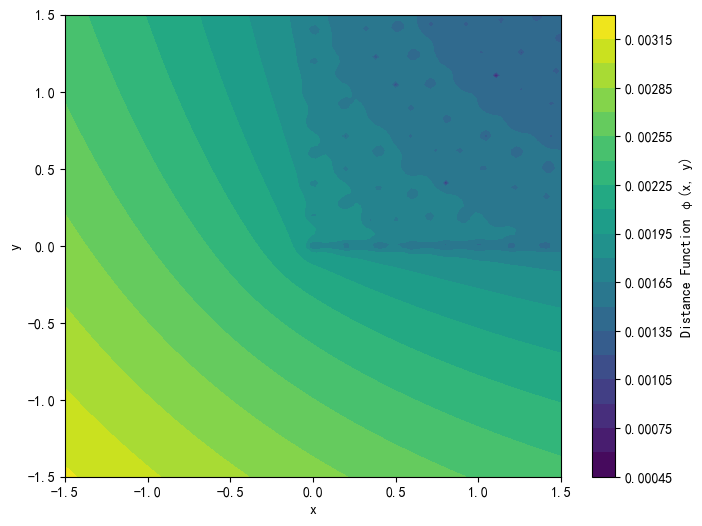

Area range: 0.008783619898745376 0.03312406413762796
Negative gradients: 15362/30924 (49.68%)


In [ ]:
loss_threshold = 3210648.5
loss_threshold = 0
# 指定 .inp 文件路径
# file_path_ = r"D:\PINN\Strong_imposed\2D\strip\strip.inp"
# txt_path = r"D:\Jupyter\CW_hidenn\txt\strip"

# txt_data_coord = r"D:\Jupyter\CW_hidenn\txt\strip\coord_all.txt"
# txt_data_u = r"D:\Jupyter\CW_hidenn\txt\strip\u_all.txt"
# txt_data_s = r"D:\Jupyter\CW_hidenn\txt\strip\s_all.txt"

# path_mesh = r"D:\Jupyter\CW_hidenn\fig\strip\mesh.jpg"
##################
data_coord = np.loadtxt(txt_data_coord)
data_u = np.loadtxt(txt_data_u)
data_s = np.loadtxt(txt_data_s)
##################
faces_x = torch.tensor([
[[4.0, 10.0],[6.0, 10.0]],
[[0.0, 0.0],[10.0, 0.0]],
[[0.0, 0.0],[0.0, 10.0]],
[[10.0, 0.0],[10.0, 10.0]]
])
faces_y = torch.tensor([
[[4.0, 10.0],[6.0, 10.0]],
[[0.0, 0.0],[10.0, 0.0]]

])
data_x = torch.tensor(data_coord)
data_y = torch.tensor(data_coord)

nodes_, elements, node_sets, element_type = extract_mesh_from_inp(file_path_)
print(f"成功提取网格信息：")
print(f"节点数: {len(nodes_)}")
print(f"元素数: {len(elements)}")
print(f"节点集: {list(node_sets.keys())}")
print(f"元素类型: {element_type}")

plot_phi(faces_y,data_y,n_grid=100)



nodes = np.array([n[1:3] for n in nodes_])  # 提取 x, y, z
elements = np.array(elements)  # 直接使用节点索引


### 生成积分点,单元面积 ###
areas,gp = generate_gp(nodes, elements)

# plot_2d_mesh(nodes_, elements, gp, path_mesh, line_width=0.2, gp_color='red', gp_size=1)
# MLS 形函数
    ## gp_shape, gp_shape_grads
gp_shape, gp_shape_grad = compute_shape_functions(nodes, elements)


##########

activation='tanh'
initial_lr=0.01
sadap = True
rho, E, nu = 1.0, 0.0, 0.0

bc_x = [0,0,0,0]
bc_y = [-1,0]

bc_data_x = data_u[:,0]
bc_data_y = data_u[:,1]
bc_data_s11 = data_s[:,0]
bc_data_s22 = data_s[:,1]
bc_data_s12 = data_s[:,2]


bc_x = bc_x + bc_data_x.tolist()

bc_y = bc_y + bc_data_y.tolist()
bc_s11 = bc_data_s11.tolist()
bc_s22 = bc_data_s22.tolist()
bc_s12 = bc_data_s12.tolist()

model = PINNs(
    activation, 
    device,
    initial_lr, sadap,
    rho, E, nu,
    faces_x, faces_y, bc_x, bc_y, bc_s11, bc_s22, bc_s12,
    data_x, data_y,
    gp,  gp_shape, gp_shape_grad, areas,
    nodes,
    loss_threshold

)

MAIN

In [30]:
model.train_res(epochs=50000)

Epoch 478, Loss: 3210648.500000, E: 0.000000, nu: 0.000000, :   1%|          | 479/50000 [00:21<36:41, 22.50it/s]


KeyboardInterrupt: 

In [ ]:

a_E = 5000
a_nu = 0.3
def lamb_params(E, nu):
    lambda_ = E * nu / ((1 + nu) * (1 - 2 * nu))
    G = E / (2 * (1 + nu))
    print(f"E: {E}, nu: {nu}, lambda: {lambda_}, G: {G}")
    return lambda_, G

a_lamb, a_G = lamb_params(a_E, a_nu)
model_lamb, model_G = lamb_params(model.E.item(), model.nu.item())
error_lamb = abs((model_lamb - a_lamb) / a_lamb) * 100
error_G = abs((model_G - a_G) / a_G) * 100
print(f"误差: lambda: {error_lamb:.2f}%, G: {error_G:.2f}%")

0.0 0.0
0.0 0.0
E: 5000, nu: 0.3, lambda: 2884.6153846153843, G: 1923.076923076923
E: 0.0, nu: 0.0, lambda: 0.0, G: 0.0
误差: lambda: 100.00%, G: 100.00%


In [32]:
error_lamb = abs((model.lambda_.item() - a_lamb) / a_lamb) * 100
error_G = abs((model.G.item() - a_G) / a_G) * 100
print(f"误差: lambda: {error_lamb:.2f}%, G: {error_G:.2f}%")

误差: lambda: 0.04%, G: 2.94%
